In [1]:
if 'google.colab' in str(get_ipython()):
  %pip install pycocotools omrdatasettools xmlschema > /dev/null
  %pip install torchvision --upgrade > /dev/null


In [1]:
from omrdatasettools import Downloader, OmrDataset
import xmlschema

import os
import glob
import re
from PIL import Image
from lxml import etree
from pprint import pprint
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

from datasets import MuscimaObjects, MuscimaDownloader

In [2]:
muscimaroot = MuscimaDownloader.download()

dataset = MuscimaObjects.MuscimaObjects(muscimaroot)

Extracting MuscimaPlusPlus_V2 dataset...
Deleting temporary directory /scratch/users/cakarsubasi18/JupyterWorkspace/omrtorch/MuscimaPpImages
Extracting MuscimaPlusPlus_MeasureAnnotations dataset...


### Model

In [3]:
from visionutils.engine import train_one_epoch, evaluate
import visionutils.utils as utils
import visionutils.transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Initialized module


In [4]:
dataset = MuscimaObjects.MuscimaObjects(muscimaroot, transforms=get_transform(train=True))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

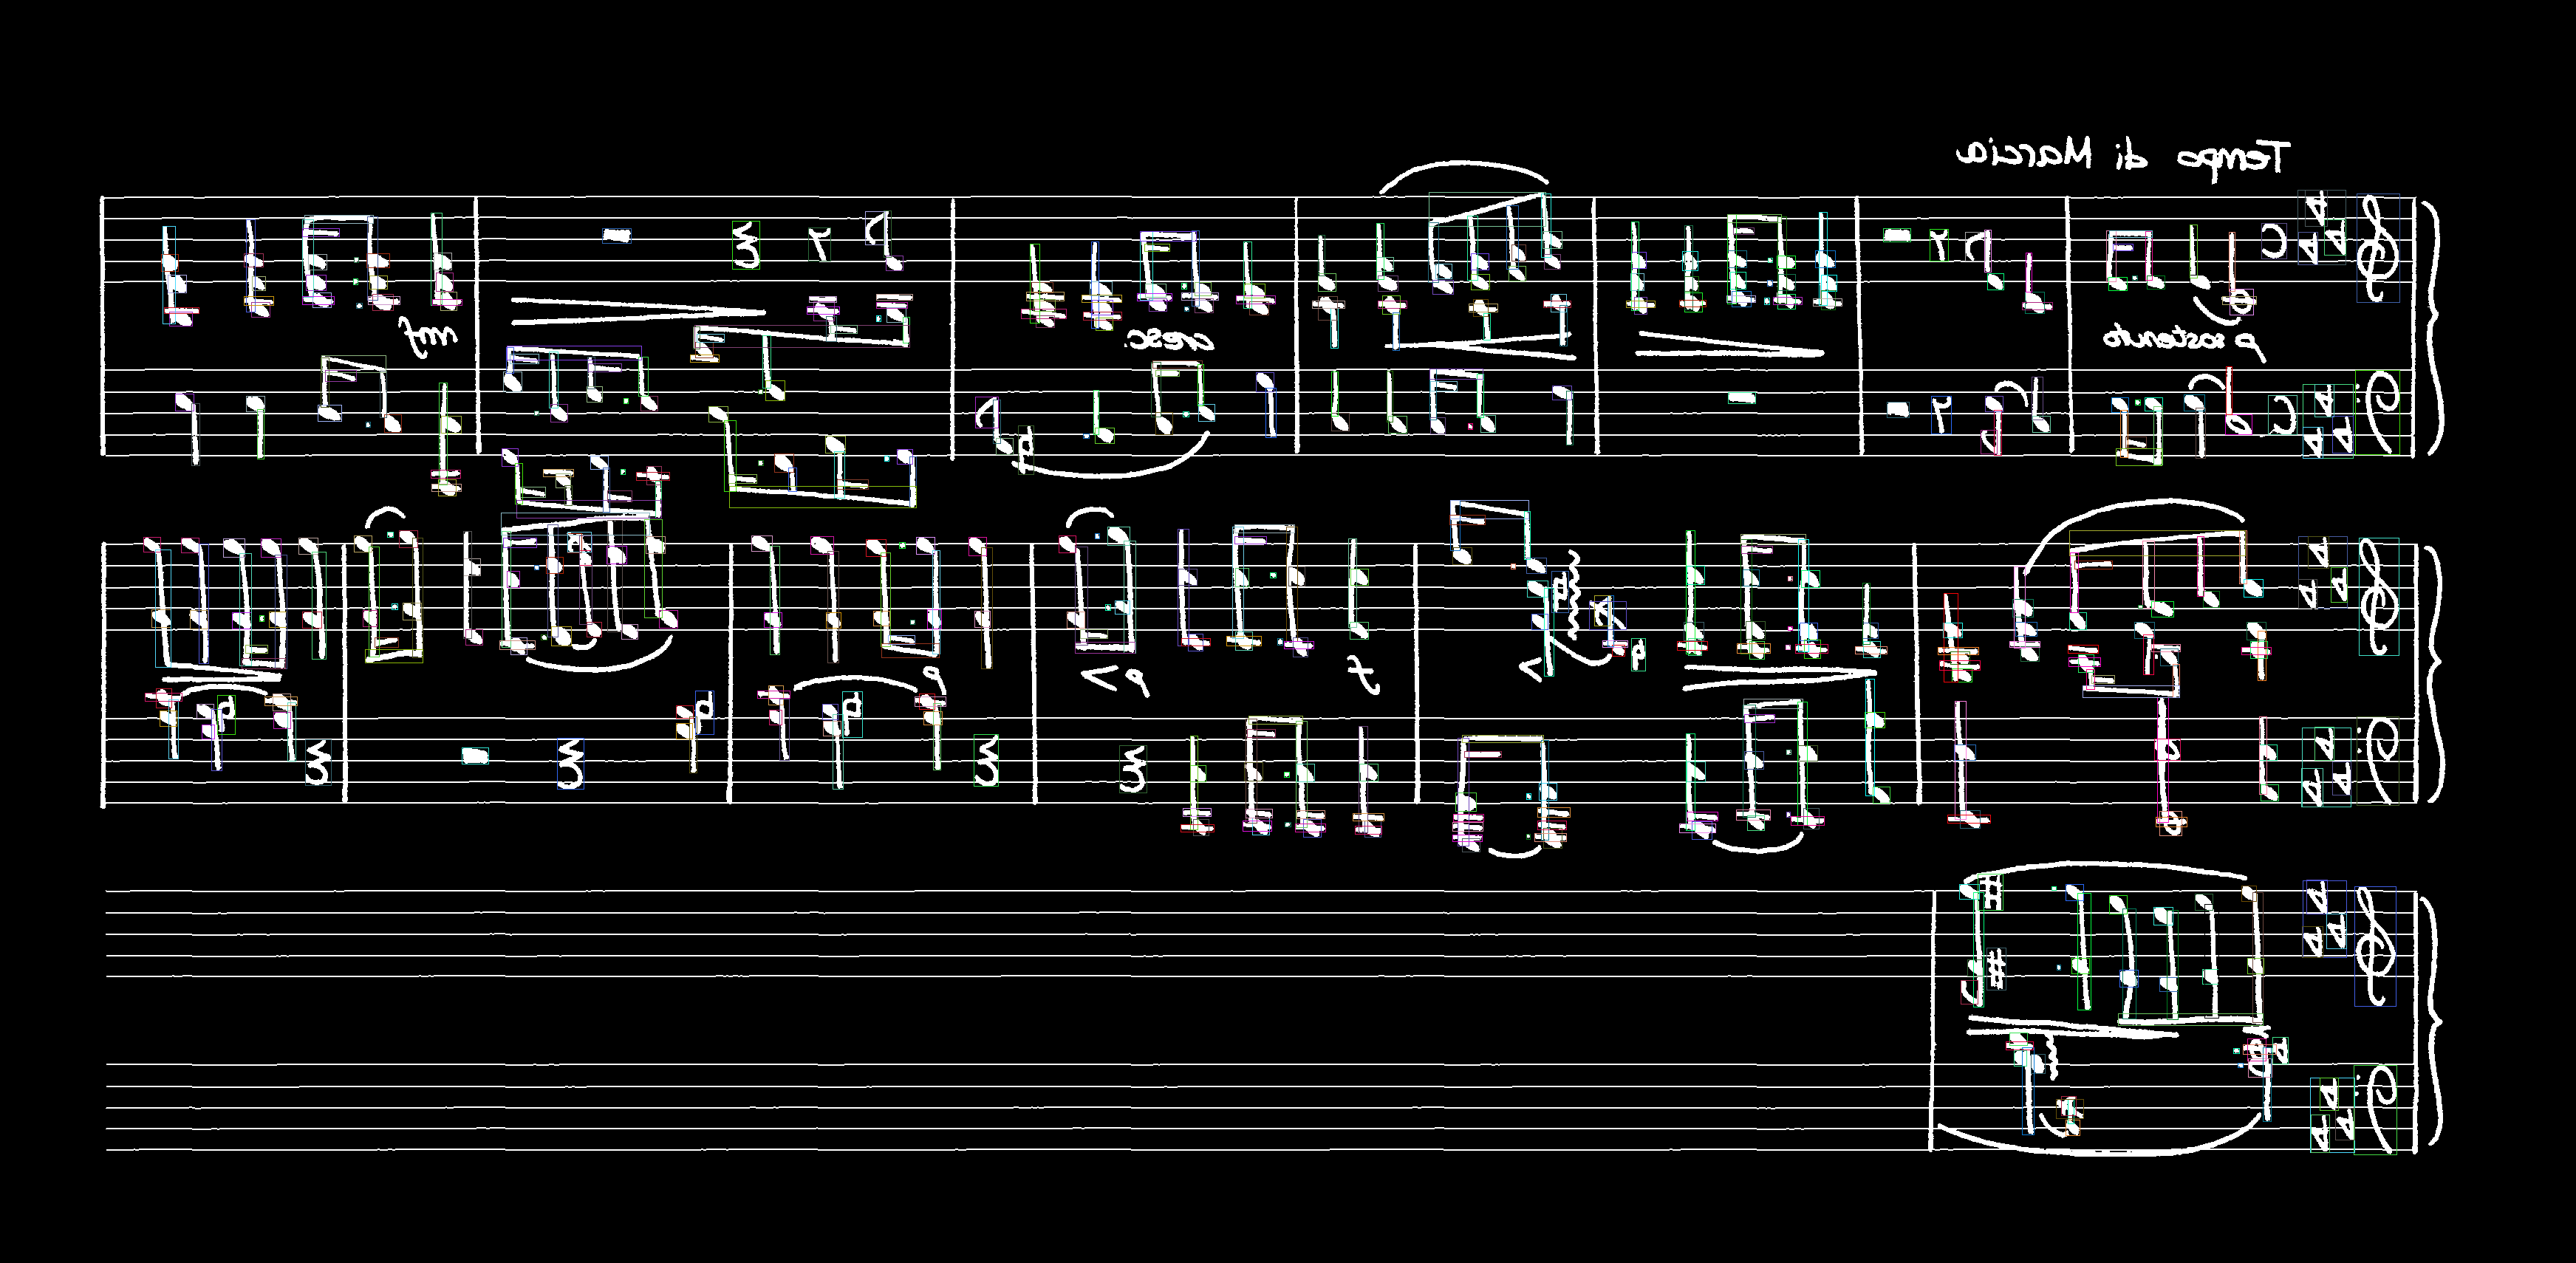

In [5]:
sample_im, sample_ann = dataset[0]
sample_boxes = sample_ann['boxes']

sample_im = (255*sample_im).type(torch.ByteTensor)

from torchvision.utils import draw_bounding_boxes


sample_im_with_bounding_boxes = draw_bounding_boxes(sample_im, sample_boxes)

sample_im_with_bounding_boxes.shape
Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))

### Model

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.anchor_utils import AnchorGenerator

# Pretrained model
# [0.12, 0.24, 0.91, 4.97] - standard reduced symbols
# [0.34, 0.6, 0.88, 1.21] - pitch info only
def get_faster_rcnn_with_n_classes(n: int):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, trainable_backbone_layers=1)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.detections_per_img = 400

  aspects = (0.38, 0.75, 1.14)
  anchor_sizes = ((32,), (64,), (128,), (256,), (512,))
  aspect_ratios = (aspects,) * len(anchor_sizes)
  rpn_anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

  model.rpn.anchor_generator = rpn_anchor_generator

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n)

  return model

In [7]:
from datasets import models
#aspects = (0.12, 0.24, 0.91, 4.97)

#model = models.muscima_fpn_model(
#    len(dataset.label_list) + 1,
#    backbone='resnet50',
#    aspects=aspects)

In [8]:
label_list_pitch_only = ['noteheadFull', 'noteheadHalf', 'noteheadWhole', 'accidentalSharp', 'accidentalFlat', 'accidentalNatural',
                    'gCflef', 'fClef', 'cClef']

model = get_faster_rcnn_with_n_classes(len(label_list_pitch_only) + 1)

In [9]:
# Test

images, targets = next(iter(dataloader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#output = model(images, targets)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

In [10]:
dataset = MuscimaObjects.MuscimaObjects(muscimaroot, label_list_pitch_only, transforms=get_transform(train=True))
dataset_test = MuscimaObjects.MuscimaObjects(muscimaroot, label_list_pitch_only, transforms=get_transform(train=False))

#splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

print(len(dataset))
print(len(dataset_test))

#dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

100
40


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)

# learning rate 10x reduction every three epocs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [12]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 50

run_training_and_validation = True

if run_training_and_validation:
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/50]  eta: 0:02:02  lr: 0.000021  loss: 9.4628 (9.4628)  loss_classifier: 2.1173 (2.1173)  loss_box_reg: 0.2576 (0.2576)  loss_objectness: 6.0475 (6.0475)  loss_rpn_box_reg: 1.0403 (1.0403)  time: 2.4403  data: 0.7087  max mem: 2595
Epoch: [0]  [10/50]  eta: 0:00:46  lr: 0.000225  loss: 2.9102 (4.4403)  loss_classifier: 0.9585 (1.2610)  loss_box_reg: 0.2576 (0.2569)  loss_objectness: 0.7641 (2.0394)  loss_rpn_box_reg: 0.9208 (0.8830)  time: 1.1744  data: 0.5706  max mem: 4249
Epoch: [0]  [20/50]  eta: 0:00:32  lr: 0.000429  loss: 1.8060 (3.0558)  loss_classifier: 0.6484 (0.9181)  loss_box_reg: 0.3070 (0.3285)  loss_objectness: 0.3492 (1.1652)  loss_rpn_box_reg: 0.4603 (0.6440)  time: 1.0078  data: 0.5409  max mem: 4249
Epoch: [0]  [30/50]  eta: 0:00:21  lr: 0.000633  loss: 1.5232 (2.5733)  loss_classifier: 0.5237 (0.8103)  loss_box_reg: 0.4176 (0.3612)  loss_objectness: 0.1921 (0.8463)  loss_rpn_box_reg: 0.3475 (0.5556)  time: 0.9942  data: 0.5447  max mem: 4257
Epoch: [

Epoch: [3]  [ 0/50]  eta: 0:00:44  lr: 0.001000  loss: 1.0701 (1.0701)  loss_classifier: 0.2019 (0.2019)  loss_box_reg: 0.5175 (0.5175)  loss_objectness: 0.0809 (0.0809)  loss_rpn_box_reg: 0.2697 (0.2697)  time: 0.8853  data: 0.4119  max mem: 4533
Epoch: [3]  [10/50]  eta: 0:00:40  lr: 0.001000  loss: 0.9759 (0.9644)  loss_classifier: 0.1890 (0.2024)  loss_box_reg: 0.3919 (0.4101)  loss_objectness: 0.0962 (0.1129)  loss_rpn_box_reg: 0.2519 (0.2388)  time: 1.0121  data: 0.5285  max mem: 4533
Epoch: [3]  [20/50]  eta: 0:00:29  lr: 0.001000  loss: 0.9453 (0.9505)  loss_classifier: 0.1901 (0.2078)  loss_box_reg: 0.3919 (0.4036)  loss_objectness: 0.0962 (0.1048)  loss_rpn_box_reg: 0.2457 (0.2343)  time: 0.9930  data: 0.5228  max mem: 4533
Epoch: [3]  [30/50]  eta: 0:00:19  lr: 0.001000  loss: 0.9107 (0.9247)  loss_classifier: 0.2064 (0.2054)  loss_box_reg: 0.3834 (0.3969)  loss_objectness: 0.0807 (0.0957)  loss_rpn_box_reg: 0.2253 (0.2266)  time: 0.9804  data: 0.5186  max mem: 4533
Epoch: [

Epoch: [6]  [ 0/50]  eta: 0:00:50  lr: 0.001000  loss: 0.8873 (0.8873)  loss_classifier: 0.1783 (0.1783)  loss_box_reg: 0.3684 (0.3684)  loss_objectness: 0.0703 (0.0703)  loss_rpn_box_reg: 0.2703 (0.2703)  time: 1.0026  data: 0.5570  max mem: 4533
Epoch: [6]  [10/50]  eta: 0:00:41  lr: 0.001000  loss: 0.7605 (0.7617)  loss_classifier: 0.1469 (0.1603)  loss_box_reg: 0.3427 (0.3462)  loss_objectness: 0.0642 (0.0607)  loss_rpn_box_reg: 0.1850 (0.1946)  time: 1.0253  data: 0.5286  max mem: 4533
Epoch: [6]  [20/50]  eta: 0:00:31  lr: 0.001000  loss: 0.7952 (0.7846)  loss_classifier: 0.1520 (0.1677)  loss_box_reg: 0.3441 (0.3568)  loss_objectness: 0.0623 (0.0652)  loss_rpn_box_reg: 0.1848 (0.1949)  time: 1.0452  data: 0.5579  max mem: 4533
Epoch: [6]  [30/50]  eta: 0:00:20  lr: 0.001000  loss: 0.8010 (0.7918)  loss_classifier: 0.1660 (0.1673)  loss_box_reg: 0.3409 (0.3565)  loss_objectness: 0.0730 (0.0699)  loss_rpn_box_reg: 0.1857 (0.1980)  time: 1.0506  data: 0.5710  max mem: 4533
Epoch: [

Epoch: [9]  [ 0/50]  eta: 0:00:49  lr: 0.001000  loss: 0.6563 (0.6563)  loss_classifier: 0.1128 (0.1128)  loss_box_reg: 0.2852 (0.2852)  loss_objectness: 0.0546 (0.0546)  loss_rpn_box_reg: 0.2038 (0.2038)  time: 0.9950  data: 0.5568  max mem: 4533
Epoch: [9]  [10/50]  eta: 0:00:40  lr: 0.001000  loss: 0.7583 (0.7280)  loss_classifier: 0.1363 (0.1410)  loss_box_reg: 0.3135 (0.3061)  loss_objectness: 0.0693 (0.0741)  loss_rpn_box_reg: 0.2038 (0.2068)  time: 1.0007  data: 0.5270  max mem: 4533
Epoch: [9]  [20/50]  eta: 0:00:30  lr: 0.001000  loss: 0.7583 (0.7273)  loss_classifier: 0.1363 (0.1397)  loss_box_reg: 0.2869 (0.3041)  loss_objectness: 0.0700 (0.0745)  loss_rpn_box_reg: 0.2046 (0.2091)  time: 1.0004  data: 0.5286  max mem: 4533
Epoch: [9]  [30/50]  eta: 0:00:20  lr: 0.001000  loss: 0.7144 (0.7230)  loss_classifier: 0.1326 (0.1372)  loss_box_reg: 0.3124 (0.3156)  loss_objectness: 0.0566 (0.0695)  loss_rpn_box_reg: 0.1878 (0.2006)  time: 1.0070  data: 0.5273  max mem: 4533
Epoch: [

Epoch: [12]  [ 0/50]  eta: 0:00:46  lr: 0.000100  loss: 0.7341 (0.7341)  loss_classifier: 0.1117 (0.1117)  loss_box_reg: 0.3031 (0.3031)  loss_objectness: 0.0780 (0.0780)  loss_rpn_box_reg: 0.2413 (0.2413)  time: 0.9271  data: 0.4880  max mem: 4533
Epoch: [12]  [10/50]  eta: 0:00:39  lr: 0.000100  loss: 0.5528 (0.5760)  loss_classifier: 0.0867 (0.0903)  loss_box_reg: 0.2649 (0.2555)  loss_objectness: 0.0653 (0.0676)  loss_rpn_box_reg: 0.1608 (0.1625)  time: 1.0000  data: 0.5384  max mem: 4533
Epoch: [12]  [20/50]  eta: 0:00:29  lr: 0.000100  loss: 0.5508 (0.5577)  loss_classifier: 0.0801 (0.0829)  loss_box_reg: 0.2401 (0.2499)  loss_objectness: 0.0566 (0.0622)  loss_rpn_box_reg: 0.1534 (0.1626)  time: 1.0003  data: 0.5380  max mem: 4533
Epoch: [12]  [30/50]  eta: 0:00:20  lr: 0.000100  loss: 0.5508 (0.5736)  loss_classifier: 0.0821 (0.0869)  loss_box_reg: 0.2493 (0.2561)  loss_objectness: 0.0650 (0.0653)  loss_rpn_box_reg: 0.1534 (0.1653)  time: 1.0067  data: 0.5435  max mem: 4533
Epoc

Epoch: [15]  [ 0/50]  eta: 0:00:42  lr: 0.000100  loss: 0.5397 (0.5397)  loss_classifier: 0.0713 (0.0713)  loss_box_reg: 0.2843 (0.2843)  loss_objectness: 0.0594 (0.0594)  loss_rpn_box_reg: 0.1248 (0.1248)  time: 0.8443  data: 0.4258  max mem: 4533
Epoch: [15]  [10/50]  eta: 0:00:38  lr: 0.000100  loss: 0.5369 (0.5331)  loss_classifier: 0.0739 (0.0754)  loss_box_reg: 0.2322 (0.2411)  loss_objectness: 0.0594 (0.0547)  loss_rpn_box_reg: 0.1625 (0.1620)  time: 0.9624  data: 0.4988  max mem: 4533
Epoch: [15]  [20/50]  eta: 0:00:29  lr: 0.000100  loss: 0.5262 (0.5377)  loss_classifier: 0.0739 (0.0726)  loss_box_reg: 0.2327 (0.2422)  loss_objectness: 0.0616 (0.0614)  loss_rpn_box_reg: 0.1625 (0.1615)  time: 0.9762  data: 0.5077  max mem: 4533
Epoch: [15]  [30/50]  eta: 0:00:19  lr: 0.000100  loss: 0.5154 (0.5337)  loss_classifier: 0.0714 (0.0745)  loss_box_reg: 0.2327 (0.2419)  loss_objectness: 0.0637 (0.0595)  loss_rpn_box_reg: 0.1500 (0.1578)  time: 0.9969  data: 0.5150  max mem: 4533
Epoc

Epoch: [18]  [ 0/50]  eta: 0:00:43  lr: 0.000100  loss: 0.4179 (0.4179)  loss_classifier: 0.0429 (0.0429)  loss_box_reg: 0.2122 (0.2122)  loss_objectness: 0.0544 (0.0544)  loss_rpn_box_reg: 0.1084 (0.1084)  time: 0.8612  data: 0.4354  max mem: 4533
Epoch: [18]  [10/50]  eta: 0:00:40  lr: 0.000100  loss: 0.4993 (0.4888)  loss_classifier: 0.0526 (0.0612)  loss_box_reg: 0.2122 (0.2275)  loss_objectness: 0.0482 (0.0533)  loss_rpn_box_reg: 0.1431 (0.1468)  time: 1.0072  data: 0.5189  max mem: 4533
Epoch: [18]  [20/50]  eta: 0:00:29  lr: 0.000100  loss: 0.5118 (0.5114)  loss_classifier: 0.0656 (0.0673)  loss_box_reg: 0.2254 (0.2344)  loss_objectness: 0.0446 (0.0544)  loss_rpn_box_reg: 0.1585 (0.1552)  time: 0.9941  data: 0.5291  max mem: 4533
Epoch: [18]  [30/50]  eta: 0:00:19  lr: 0.000100  loss: 0.5103 (0.5051)  loss_classifier: 0.0703 (0.0675)  loss_box_reg: 0.2437 (0.2352)  loss_objectness: 0.0448 (0.0515)  loss_rpn_box_reg: 0.1491 (0.1509)  time: 0.9704  data: 0.5220  max mem: 4533
Epoc

Epoch: [21]  [ 0/50]  eta: 0:00:46  lr: 0.000010  loss: 0.5462 (0.5462)  loss_classifier: 0.0740 (0.0740)  loss_box_reg: 0.2548 (0.2548)  loss_objectness: 0.0720 (0.0720)  loss_rpn_box_reg: 0.1454 (0.1454)  time: 0.9303  data: 0.5068  max mem: 4533
Epoch: [21]  [10/50]  eta: 0:00:39  lr: 0.000010  loss: 0.4781 (0.4896)  loss_classifier: 0.0659 (0.0644)  loss_box_reg: 0.2305 (0.2306)  loss_objectness: 0.0483 (0.0524)  loss_rpn_box_reg: 0.1381 (0.1423)  time: 0.9893  data: 0.5205  max mem: 4533
Epoch: [21]  [20/50]  eta: 0:00:29  lr: 0.000010  loss: 0.4895 (0.4971)  loss_classifier: 0.0661 (0.0699)  loss_box_reg: 0.2208 (0.2249)  loss_objectness: 0.0498 (0.0569)  loss_rpn_box_reg: 0.1381 (0.1454)  time: 0.9919  data: 0.5221  max mem: 4533
Epoch: [21]  [30/50]  eta: 0:00:20  lr: 0.000010  loss: 0.5020 (0.5028)  loss_classifier: 0.0695 (0.0709)  loss_box_reg: 0.2121 (0.2243)  loss_objectness: 0.0666 (0.0597)  loss_rpn_box_reg: 0.1503 (0.1479)  time: 1.0121  data: 0.5294  max mem: 4533
Epoc

Epoch: [24]  [ 0/50]  eta: 0:00:48  lr: 0.000010  loss: 0.4204 (0.4204)  loss_classifier: 0.0603 (0.0603)  loss_box_reg: 0.1917 (0.1917)  loss_objectness: 0.0593 (0.0593)  loss_rpn_box_reg: 0.1090 (0.1090)  time: 0.9705  data: 0.4948  max mem: 4533
Epoch: [24]  [10/50]  eta: 0:00:40  lr: 0.000010  loss: 0.4906 (0.4799)  loss_classifier: 0.0667 (0.0703)  loss_box_reg: 0.2031 (0.2147)  loss_objectness: 0.0494 (0.0523)  loss_rpn_box_reg: 0.1450 (0.1426)  time: 1.0204  data: 0.5370  max mem: 4533
Epoch: [24]  [20/50]  eta: 0:00:30  lr: 0.000010  loss: 0.4702 (0.4828)  loss_classifier: 0.0659 (0.0685)  loss_box_reg: 0.2156 (0.2220)  loss_objectness: 0.0494 (0.0552)  loss_rpn_box_reg: 0.1354 (0.1371)  time: 1.0216  data: 0.5331  max mem: 4533
Epoch: [24]  [30/50]  eta: 0:00:19  lr: 0.000010  loss: 0.4979 (0.4936)  loss_classifier: 0.0609 (0.0685)  loss_box_reg: 0.2178 (0.2245)  loss_objectness: 0.0596 (0.0569)  loss_rpn_box_reg: 0.1372 (0.1437)  time: 0.9826  data: 0.5133  max mem: 4533
Epoc

Epoch: [28]  [ 0/50]  eta: 0:00:55  lr: 0.000010  loss: 0.3655 (0.3655)  loss_classifier: 0.0449 (0.0449)  loss_box_reg: 0.1730 (0.1730)  loss_objectness: 0.0404 (0.0404)  loss_rpn_box_reg: 0.1072 (0.1072)  time: 1.1037  data: 0.5785  max mem: 4533
Epoch: [28]  [10/50]  eta: 0:00:39  lr: 0.000010  loss: 0.4715 (0.4691)  loss_classifier: 0.0585 (0.0578)  loss_box_reg: 0.2235 (0.2143)  loss_objectness: 0.0597 (0.0589)  loss_rpn_box_reg: 0.1312 (0.1381)  time: 0.9814  data: 0.5142  max mem: 4533
Epoch: [28]  [20/50]  eta: 0:00:30  lr: 0.000010  loss: 0.4820 (0.4831)  loss_classifier: 0.0585 (0.0655)  loss_box_reg: 0.2235 (0.2189)  loss_objectness: 0.0606 (0.0610)  loss_rpn_box_reg: 0.1312 (0.1377)  time: 1.0072  data: 0.5272  max mem: 4533
Epoch: [28]  [30/50]  eta: 0:00:20  lr: 0.000010  loss: 0.4820 (0.4891)  loss_classifier: 0.0647 (0.0653)  loss_box_reg: 0.2239 (0.2220)  loss_objectness: 0.0606 (0.0605)  loss_rpn_box_reg: 0.1364 (0.1413)  time: 1.0315  data: 0.5377  max mem: 4533
Epoc

Epoch: [31]  [ 0/50]  eta: 0:00:50  lr: 0.000001  loss: 0.4841 (0.4841)  loss_classifier: 0.0640 (0.0640)  loss_box_reg: 0.2365 (0.2365)  loss_objectness: 0.0512 (0.0512)  loss_rpn_box_reg: 0.1324 (0.1324)  time: 1.0170  data: 0.5828  max mem: 4533
Epoch: [31]  [10/50]  eta: 0:00:39  lr: 0.000001  loss: 0.4674 (0.4844)  loss_classifier: 0.0640 (0.0626)  loss_box_reg: 0.2250 (0.2311)  loss_objectness: 0.0512 (0.0526)  loss_rpn_box_reg: 0.1324 (0.1380)  time: 0.9915  data: 0.5170  max mem: 4533
Epoch: [31]  [20/50]  eta: 0:00:29  lr: 0.000001  loss: 0.4674 (0.4919)  loss_classifier: 0.0555 (0.0658)  loss_box_reg: 0.2250 (0.2273)  loss_objectness: 0.0500 (0.0546)  loss_rpn_box_reg: 0.1374 (0.1442)  time: 0.9772  data: 0.5081  max mem: 4533
Epoch: [32]  [30/50]  eta: 0:00:20  lr: 0.000001  loss: 0.4892 (0.4956)  loss_classifier: 0.0653 (0.0661)  loss_box_reg: 0.2129 (0.2209)  loss_objectness: 0.0551 (0.0588)  loss_rpn_box_reg: 0.1501 (0.1499)  time: 1.0243  data: 0.5348  max mem: 4533
Epoc

Epoch: [35]  [ 0/50]  eta: 0:00:46  lr: 0.000001  loss: 0.3908 (0.3908)  loss_classifier: 0.0568 (0.0568)  loss_box_reg: 0.1937 (0.1937)  loss_objectness: 0.0352 (0.0352)  loss_rpn_box_reg: 0.1051 (0.1051)  time: 0.9290  data: 0.5407  max mem: 4533
Epoch: [35]  [10/50]  eta: 0:00:42  lr: 0.000001  loss: 0.4863 (0.4844)  loss_classifier: 0.0568 (0.0648)  loss_box_reg: 0.2239 (0.2158)  loss_objectness: 0.0560 (0.0566)  loss_rpn_box_reg: 0.1514 (0.1472)  time: 1.0683  data: 0.5999  max mem: 4533
Epoch: [35]  [20/50]  eta: 0:00:31  lr: 0.000001  loss: 0.4918 (0.4904)  loss_classifier: 0.0682 (0.0664)  loss_box_reg: 0.2152 (0.2146)  loss_objectness: 0.0553 (0.0579)  loss_rpn_box_reg: 0.1538 (0.1515)  time: 1.0612  data: 0.5763  max mem: 4538
Epoch: [35]  [30/50]  eta: 0:00:20  lr: 0.000001  loss: 0.4974 (0.4869)  loss_classifier: 0.0661 (0.0647)  loss_box_reg: 0.2152 (0.2171)  loss_objectness: 0.0509 (0.0579)  loss_rpn_box_reg: 0.1538 (0.1472)  time: 0.9911  data: 0.5259  max mem: 4538
Epoc

Epoch: [38]  [ 0/50]  eta: 0:00:52  lr: 0.000001  loss: 0.4729 (0.4729)  loss_classifier: 0.0680 (0.0680)  loss_box_reg: 0.2078 (0.2078)  loss_objectness: 0.0486 (0.0486)  loss_rpn_box_reg: 0.1485 (0.1485)  time: 1.0434  data: 0.5428  max mem: 4538
Epoch: [38]  [10/50]  eta: 0:00:43  lr: 0.000001  loss: 0.4729 (0.4856)  loss_classifier: 0.0596 (0.0633)  loss_box_reg: 0.2270 (0.2270)  loss_objectness: 0.0498 (0.0556)  loss_rpn_box_reg: 0.1409 (0.1397)  time: 1.0761  data: 0.6044  max mem: 4538
Epoch: [38]  [20/50]  eta: 0:00:30  lr: 0.000001  loss: 0.4919 (0.4977)  loss_classifier: 0.0598 (0.0659)  loss_box_reg: 0.2270 (0.2291)  loss_objectness: 0.0527 (0.0596)  loss_rpn_box_reg: 0.1364 (0.1431)  time: 1.0286  data: 0.5664  max mem: 4538
Epoch: [38]  [30/50]  eta: 0:00:20  lr: 0.000001  loss: 0.4943 (0.4963)  loss_classifier: 0.0678 (0.0665)  loss_box_reg: 0.2169 (0.2244)  loss_objectness: 0.0554 (0.0587)  loss_rpn_box_reg: 0.1453 (0.1466)  time: 0.9933  data: 0.5317  max mem: 4538
Epoc

Epoch: [41]  [ 0/50]  eta: 0:00:48  lr: 0.000000  loss: 0.5353 (0.5353)  loss_classifier: 0.0677 (0.0677)  loss_box_reg: 0.2491 (0.2491)  loss_objectness: 0.0636 (0.0636)  loss_rpn_box_reg: 0.1549 (0.1549)  time: 0.9772  data: 0.5297  max mem: 4538
Epoch: [41]  [10/50]  eta: 0:00:39  lr: 0.000000  loss: 0.4614 (0.4786)  loss_classifier: 0.0601 (0.0631)  loss_box_reg: 0.2295 (0.2243)  loss_objectness: 0.0516 (0.0547)  loss_rpn_box_reg: 0.1360 (0.1364)  time: 0.9879  data: 0.5277  max mem: 4538
Epoch: [41]  [20/50]  eta: 0:00:29  lr: 0.000000  loss: 0.4696 (0.4968)  loss_classifier: 0.0612 (0.0669)  loss_box_reg: 0.2168 (0.2219)  loss_objectness: 0.0510 (0.0545)  loss_rpn_box_reg: 0.1509 (0.1536)  time: 0.9952  data: 0.5222  max mem: 4538
Epoch: [41]  [30/50]  eta: 0:00:19  lr: 0.000000  loss: 0.4721 (0.4886)  loss_classifier: 0.0694 (0.0665)  loss_box_reg: 0.2028 (0.2180)  loss_objectness: 0.0534 (0.0557)  loss_rpn_box_reg: 0.1478 (0.1484)  time: 0.9983  data: 0.5240  max mem: 4538
Epoc

Epoch: [44]  [ 0/50]  eta: 0:00:43  lr: 0.000000  loss: 0.4315 (0.4315)  loss_classifier: 0.0487 (0.0487)  loss_box_reg: 0.2136 (0.2136)  loss_objectness: 0.0442 (0.0442)  loss_rpn_box_reg: 0.1250 (0.1250)  time: 0.8675  data: 0.3992  max mem: 4538
Epoch: [44]  [10/50]  eta: 0:00:39  lr: 0.000000  loss: 0.5163 (0.4981)  loss_classifier: 0.0573 (0.0653)  loss_box_reg: 0.2170 (0.2280)  loss_objectness: 0.0651 (0.0583)  loss_rpn_box_reg: 0.1492 (0.1465)  time: 0.9876  data: 0.5154  max mem: 4538
Epoch: [44]  [20/50]  eta: 0:00:29  lr: 0.000000  loss: 0.4677 (0.4810)  loss_classifier: 0.0573 (0.0621)  loss_box_reg: 0.2050 (0.2233)  loss_objectness: 0.0561 (0.0544)  loss_rpn_box_reg: 0.1357 (0.1412)  time: 0.9913  data: 0.5329  max mem: 4538
Epoch: [44]  [30/50]  eta: 0:00:19  lr: 0.000000  loss: 0.4570 (0.4760)  loss_classifier: 0.0519 (0.0607)  loss_box_reg: 0.2046 (0.2199)  loss_objectness: 0.0517 (0.0552)  loss_rpn_box_reg: 0.1369 (0.1402)  time: 0.9854  data: 0.5312  max mem: 4538
Epoc

Epoch: [47]  [ 0/50]  eta: 0:00:52  lr: 0.000000  loss: 0.3666 (0.3666)  loss_classifier: 0.0395 (0.0395)  loss_box_reg: 0.1801 (0.1801)  loss_objectness: 0.0341 (0.0341)  loss_rpn_box_reg: 0.1129 (0.1129)  time: 1.0430  data: 0.5254  max mem: 4538
Epoch: [47]  [10/50]  eta: 0:00:41  lr: 0.000000  loss: 0.4687 (0.4549)  loss_classifier: 0.0552 (0.0571)  loss_box_reg: 0.2156 (0.2101)  loss_objectness: 0.0608 (0.0539)  loss_rpn_box_reg: 0.1157 (0.1338)  time: 1.0289  data: 0.5389  max mem: 4538
Epoch: [47]  [20/50]  eta: 0:00:30  lr: 0.000000  loss: 0.4687 (0.4763)  loss_classifier: 0.0668 (0.0663)  loss_box_reg: 0.2164 (0.2170)  loss_objectness: 0.0597 (0.0542)  loss_rpn_box_reg: 0.1367 (0.1389)  time: 0.9985  data: 0.5267  max mem: 4538
Epoch: [47]  [30/50]  eta: 0:00:19  lr: 0.000000  loss: 0.4537 (0.4712)  loss_classifier: 0.0638 (0.0648)  loss_box_reg: 0.2175 (0.2159)  loss_objectness: 0.0550 (0.0533)  loss_rpn_box_reg: 0.1340 (0.1372)  time: 0.9709  data: 0.5165  max mem: 4538
Epoc

In [16]:
# Since the outputs stop updating when the Jupyter Kernel disconnects, run evaluation one more time
# to print results
evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/40]  eta: 0:00:25  model_time: 0.1312 (0.1312)  evaluator_time: 0.2289 (0.2289)  time: 0.6442  data: 0.2799  max mem: 4538
Test:  [39/40]  eta: 0:00:00  model_time: 0.1035 (0.1029)  evaluator_time: 0.3011 (0.2899)  time: 0.6946  data: 0.2862  max mem: 4538
Test: Total time: 0:00:27 (0.6897 s / it)
Averaged stats: model_time: 0.1035 (0.1029)  evaluator_time: 0.3011 (0.2899)
Accumulating evaluation results...
DONE (t=0.06s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.146
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.161
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=

###Visualization

In [14]:
def visualize_bboxes(image, target, labels=None, threshold=0.5):
    colors = ['000000', 'red', 'blue', 'green', 'yellow']
    sample_boxes = target['boxes']
    sample_scores = target['scores']
    sample_labels = target['labels']
    idx = torch.where(sample_scores > threshold)
    boxes_sliced = sample_boxes[idx]
    labels_sliced = sample_labels[idx].tolist()
    labels_list_str = None
    if labels is not None:
        labels_list_str = list(labels[val] for val in labels_sliced)
        colors_list = list(colors[val] for val in labels_sliced)
    sample_image = (image*255).type(torch.ByteTensor)

    sample_im_with_bounding_boxes = draw_bounding_boxes(sample_image, boxes_sliced, colors='red', width=3, font_size=32)

    return Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))


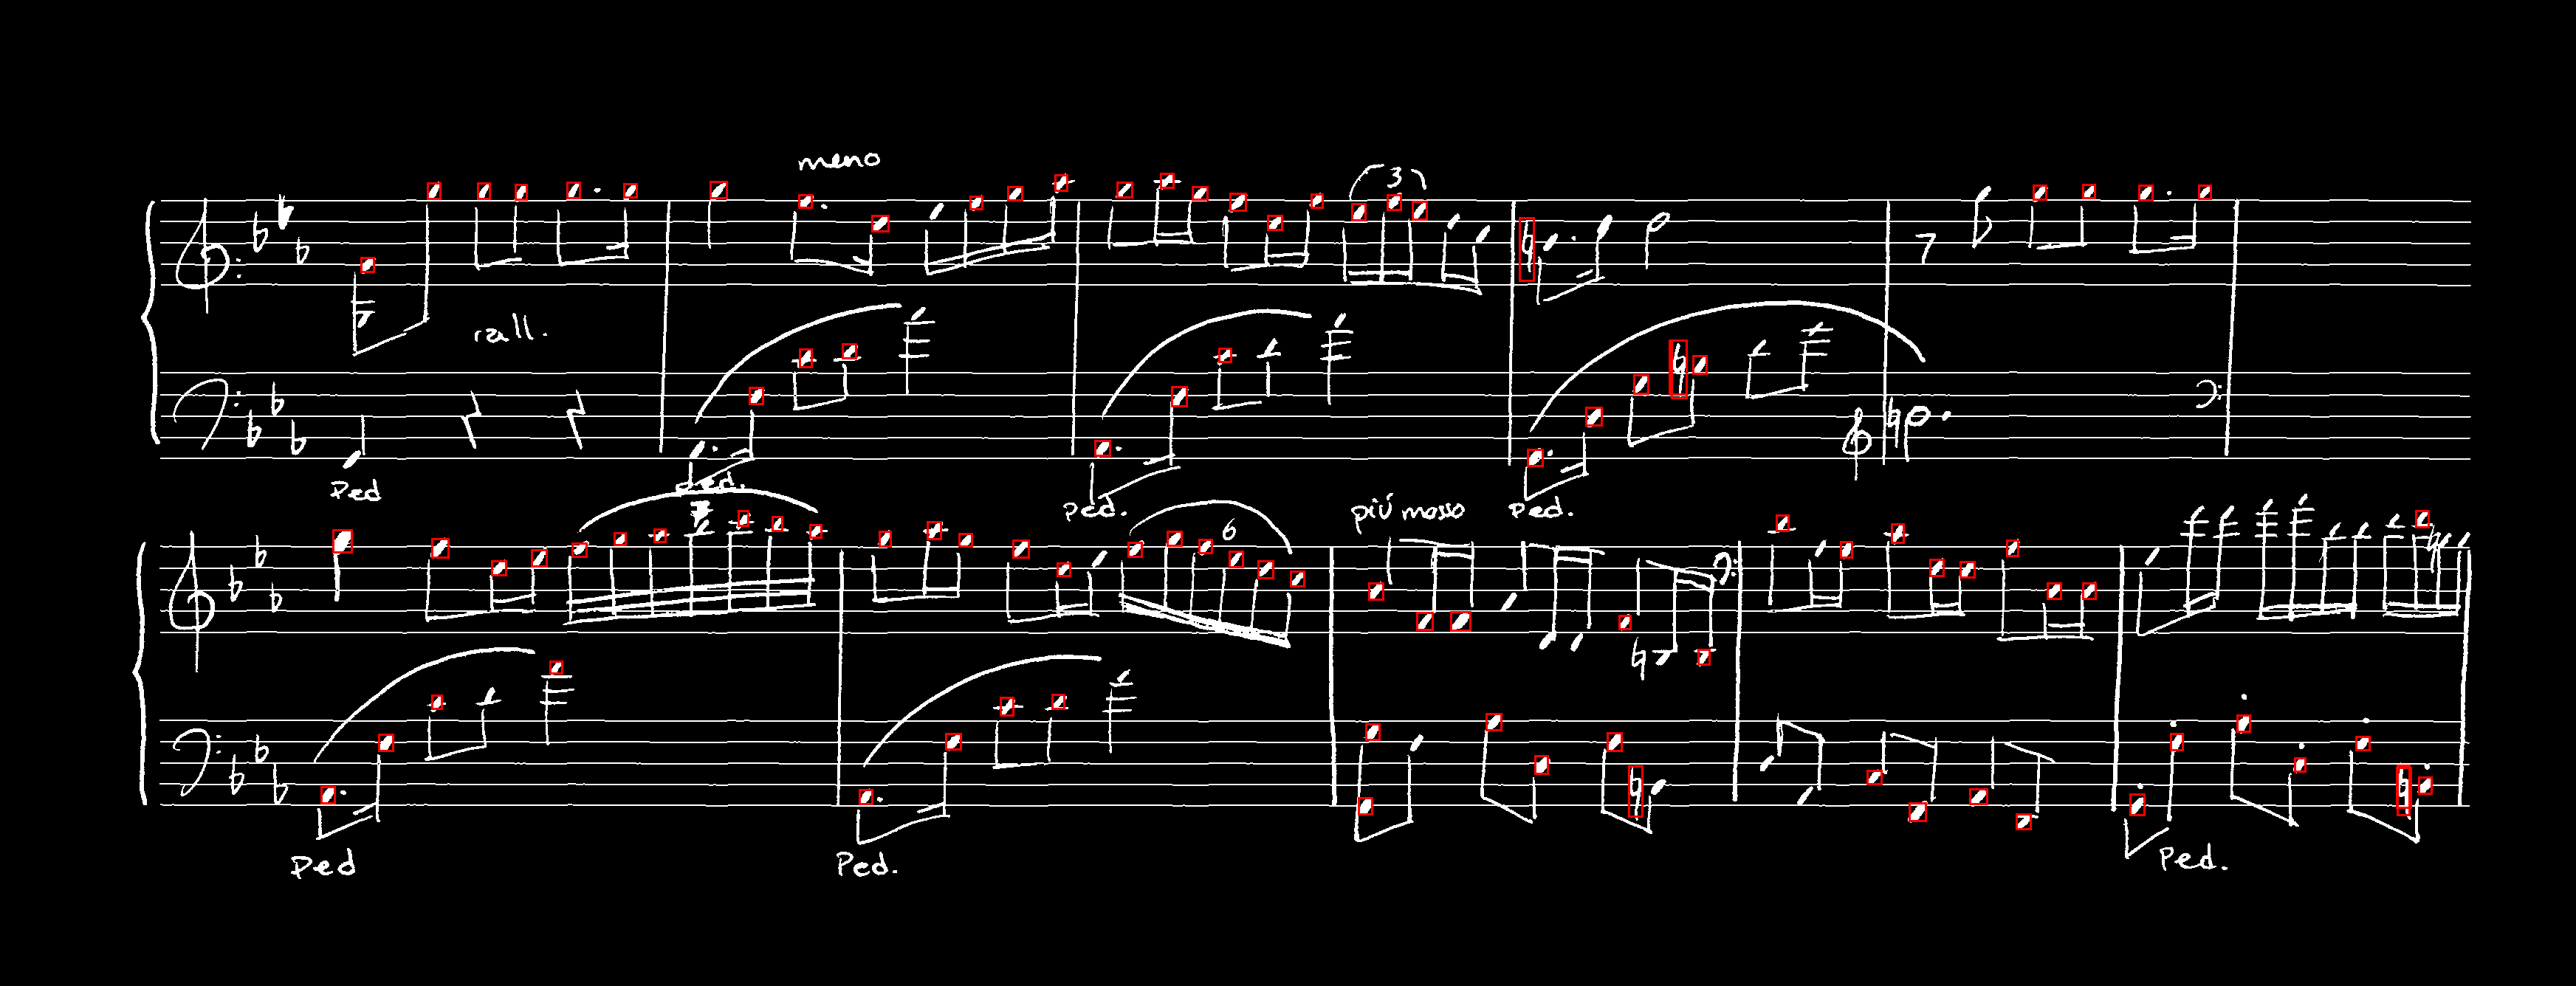

In [15]:
model.eval()
if torch.cuda.is_available():
  torch.cuda.synchronize()
image, target = next(iter(data_loader_test))
image = list(img.to(torch.device('cuda')) for img in image)
detections = model(image)
visualize_bboxes(image[0], detections[0], threshold=0.1)

In [14]:
detections[0]['boxes'].shape
#torch.sum(detections[0]['labels']==1)

torch.Size([106, 4])

In [17]:
# Example save everything
SAVE_ENTIRE_MODEL = "muscima_objects_0146.pt"

torch.save(model, SAVE_ENTIRE_MODEL)

In [ ]:
# 15 epochs, Adam, lr=0.001, *0.1 every 5 epochs, 0.135 mAP with custom aspect ratios
# 15 epochs, Adam, lr=0.001, *0.1 every 5 epochs, 0.113 mAP with default aspect ratios
# 50 epochs, Adam, Lr=0.001, *0.1 every 10 epochs, 0.146 mAP with custom aspect ratios